## Shape clean-up
The previous steps results in shapefiles per gauge, where the semi-distributed shapes do not yet take nested gauges into account. Here, we:
1. Ensure that every polygon in the shapefiles has a unique identifier (currently nested gauges within a single MERIT basin polygon all carry the same COMID)
2. Ensure that in the case of nested gauges, a more downstream gauge still has its polygon split at a more upstream gauge.

In [2]:
import numpy as np
import os
from shapely import Point
import shutil
import sys
import geopandas as gpd
import pandas as pd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [3]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

# Backup folder
cs_backup_path = cs.read_from_config(config_file, 'backup_path')

In [4]:
basin_path = Path(data_path) / cs_basin_folder / 'basin_data' # This should exist at this point of the workflow

### Data loading

In [5]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

### Create a backup of all shapes

In [6]:
# Main folder for backups
backup_folder = Path(cs_backup_path) / 'basin_shapes'
backup_folder.mkdir(exist_ok=True, parents=True)

# Log file
backup_file = backup_folder / '_log_reason.txt'
lines = [
    "Captain's log. Star date 2024-08-07.\n",
    "Creating a backup of all basin shapefiles so that we can modify the existing ones in place.\n",
    "The shapefiles in this backup have successfully been used to process all the forcing data \n",
    "(ERA5, EM-Earth, RDRS, Daymet).\n"
]

In [7]:
# Check if the backup folder is empty
# If it's not, that implies we already created a backup and we don't want to accidentally overwrite that
if Path(backup_file).is_file():
    print(f"Backup file {backup_file} already exists.")
    print(f"This implies a backup has already been created. Not copying anything now. Override manually if needed.")

else:
    if len(os.listdir(backup_folder)) > 0:
        print(f"Backup folder {backup_folder} did not contain log file {backup_file} but does contain folders/files.")
        print(f"This implies a backup has already been created. Not copying anything now. Override manually if needed.")

    else:
        # Write the log file
        with open(backup_file, 'w') as f:
            f.writelines(lines)

        # Loop over all basins and copy the basin shapes to the backup folder
        for ix,row in cs_meta.iterrows():
        
            # Create the basin identifier
            basin_str = '_'.join([row['Country'],row['Station_id']])
        
            # Create the folder paths
            lump_folder = basin_path / basin_str / 'shapefiles' / 'lumped'
            dist_folder = basin_path / basin_str / 'shapefiles' / 'distributed'
        
            # Make the backup folder
            base_folder = backup_folder / basin_str / 'shapefiles'
            base_folder.mkdir(parents=True, exist_ok=True)
        
            # Copy the folders and contents
            shutil.copytree(lump_folder, base_folder / 'lumped')
            shutil.copytree(dist_folder, base_folder / 'distributed')

Backup file /gpfs/tp/gwf/gwf_cmt/wknoben/camels_spat/backups/basin_shapes/_log_reason.txt already exists.
This implies a backup has already been created. Not copying anything now. Override manually if needed.


### Remove all the vritually-no area parts of multipolygons in the distributed shapes
We have multipolygons in two cases:
- Diagonally connected pixels in very narrow parts of each (sub)-basin;
- Processing quirks in most-downstream polygons where we have subset an existing MERIT subbasin to a gauge. In such cases we sometimes get zero-width edges of the larger polygon as part of our subsetted polygon (see below).

We'll assume here that if:
1. Multiploygon parts touch one another, together they form an area we want to keep and we have a multipolygon due to how diagonal connections are handled.
2. If parts of a multipolygon do not touch one another, this _may_ be one of the downstream processing quirks we would like to fix.

#### Example of downstream polygon processing quirk

In [8]:
import matplotlib.pyplot as plt
import warnings
from shapely.errors import ShapelyDeprecationWarning

In [9]:
basin_str = 'CAN_01AD002'
dist_shp_basin = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_basin.shp')
shp_basin = gpd.read_file(dist_shp_basin)
outlet_id = 14

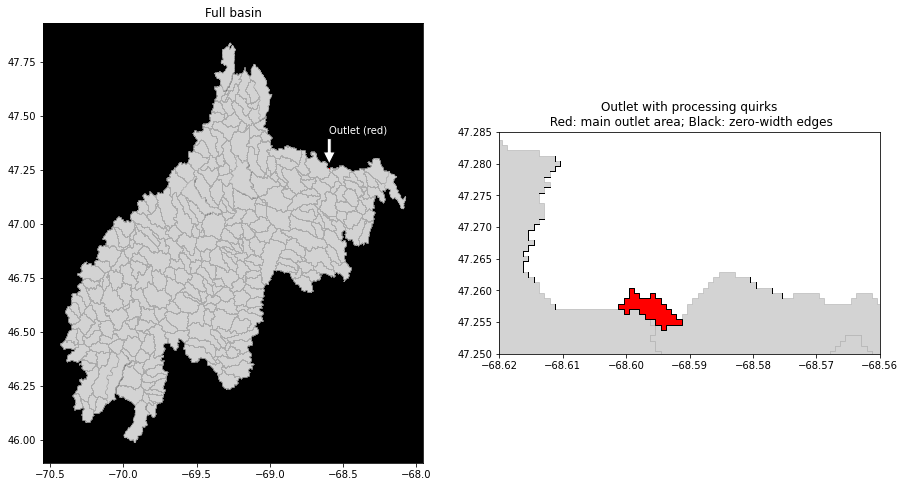

In [10]:
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # warning off: doesn't matter here
    
fig, axs = plt.subplots(1,2, figsize=(15,10))

axs[0].set_title('Full basin')
axs[0].set_facecolor('black')
shp_basin.plot(ax=axs[0], color='lightgrey', edgecolor='darkgrey', linewidth=.5)
shp_basin.iloc[[outlet_id]].plot(ax=axs[0],color='red')
x,y = -68.595,47.27
axs[0].annotate(
    'Outlet (red)',  # Annotation text
    xy=(x, y),        # Coordinates in plot CRS
    xytext=(x, y + .15),  # Position of the annotation text
    textcoords='data',
    arrowprops=dict(facecolor='white', shrink=0.05),
    color='white'
)

axs[1].set_title('Outlet with processing quirks\n Red: main outlet area; Black: zero-width edges')
shp_basin.plot(ax=axs[1], color='lightgrey', edgecolor='darkgrey', linewidth=.5)
outlet = shp_basin.iloc[outlet_id]['geometry']
gpd.GeoSeries([outlet]).plot(ax=axs[1], color='red', edgecolor='black')
axs[1].set_xlim([-68.62,-68.56])
axs[1].set_ylim([47.25,47.285])

warnings.filterwarnings("default", category=ShapelyDeprecationWarning) # warnings back on

#### How many multipolygons are we dealing with?

In [11]:
from shapely.geometry import MultiPolygon # need this for type checking

In [12]:
def are_multipolygon_parts_connected(multipolygon):
    """Check if the parts of a multipolygon are connected."""
    # Get the individual polygons from the multipolygon
    polygons = list(multipolygon.geoms)
    
    # Iterate over pairs of polygons to check connectivity
    for i in range(len(polygons)):
        for j in range(i + 1, len(polygons)):
            if polygons[i].touches(polygons[j]):
                return True
    return False

In [13]:
# First, check how often this happens at all
basins = []
has_multipolygons = []
num_multipolygons = []
len_multipolygons = []
con_multipolygons = [] # multipoly parts are connected or not?

for ix,row in cs_meta.iterrows():
    
    # Construct the path to the distributed shapefile
    basin_str = '_'.join([row['Country'],row['Station_id']])
    dist_shp_basin = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_basin.shp')
    
    # Open the shape 
    shp_basin = gpd.read_file(dist_shp_basin)

    # Loop over the geometries and check
    has_mp = False
    num_mp = 0
    len_mp = []
    con_mp = []
    for index, row in shp_basin.iterrows():
        geometry = row['geometry']
        if isinstance(geometry, MultiPolygon):
            # Properties
            num_polys = len(geometry.geoms)
            connected = are_multipolygon_parts_connected(geometry)

            # Save
            has_mp = True
            num_mp += 1
            len_mp.append(num_polys)
            con_mp.append(connected)
            #print(f"Row {index: 4}: Geometry is a MultiPolygon with {num_polys: 3} elements. Elements connected = {connected}.")

    # Save stats after we've looped over this entire basin
    basins.append(basin_str)
    has_multipolygons.append(has_mp)
    num_multipolygons.append(num_mp)
    len_multipolygons.append(len_mp)
    con_multipolygons.append(con_mp)

In [14]:
print(f"MultiPolygons present in {has_multipolygons.count(True)} distributed basin shapefiles.")
print(f"In total, there are {sum(num_multipolygons)} MultiPolygons across these shapefiles.")
print(f"{sum(mp.count(False) for mp in con_multipolygons)} of these MultiPolygons have unconnected parts.")

MultiPolygons present in 1298 distributed basin shapefiles.
In total, there are 45140 MultiPolygons across these shapefiles.
1117 of these MultiPolygons have unconnected parts.


In [15]:
# Check the number of MultiPolygons with unconnected parts per basin
unconnected_multipolgyons = []
for basin,con_mp in zip(basins, con_multipolygons): # str, list([True, False, True, ..])
    if con_mp.count(False) > 0:
        uncon_mp = con_mp.count(False)
        unconnected_multipolgyons.append(uncon_mp)
        #print(f"Basin {basin} contains {} MultiPolygons with unconnected parts.")

In [16]:
print(f"Min number of MultiPolygons with unconnected parts = {min(unconnected_multipolgyons)}.")
print(f"Max number of MultiPolygons with unconnected parts = {max(unconnected_multipolgyons)}.")

Min number of MultiPolygons with unconnected parts = 1.
Max number of MultiPolygons with unconnected parts = 14.


Given this, it seems we cannot simply assume "if MultiPolygon with unconnected parts, must be most downstream polygon".

#### Check how many downstream polygons have unconnected multipolygons

In [17]:
def find_outlet(shp, segment_id='COMID', down_id='NextDownID'):
    '''Traverses down_id column to find the segment_id of the outlet for a given geodataframe.
    Assumes that the network all ends in the same outlet.
    '''
    outlet = None
    check_row = 0 # Start at the top for no particular reason
    prev_id = shp[segment_id].iloc[check_row]
    while outlet is None:
        next_down_id = shp[down_id].iloc[check_row]
        down_id_in_segment_id = (shp[segment_id] == next_down_id)
        if not down_id_in_segment_id.any(): # NextDownID not in COMID, therefore we have found the outlet at the previous iteration
            outlet = prev_id # exits loop
        else:
            prev_id = next_down_id
            check_row = down_id_in_segment_id.index[down_id_in_segment_id].to_list()
            # Account for a possible case where the NextDownID occurs multiple times
            # Shouldn't happen but might as well make sure
            if len(check_row) > 1:
                print(f"Warning: multiple occurrences of {down_id} {next_down_id} detected. Continuing search with first occurrence.")
            check_row = check_row[0]
    
    return outlet

In [18]:
outlet_with_mp = 0
outlet_with_unconnected_mp = 0
basins_with_outlet_to_fix = []
basins_with_outlet_to_check = []
for basin_str, con_mp in zip(basins, con_multipolygons): # str, list([True, False, True, ..])
    if con_mp.count(False) > 0:

        # Load the basin and river shapes
        dist_shp_basin = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_basin.shp')
        dist_shp_river = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_river.shp')
        shp_basin = gpd.read_file(dist_shp_basin)
        shp_river = gpd.read_file(dist_shp_river)

        # Find most downstream polygon
        outlet = find_outlet(shp_river)

        # Check if this most downstream polygon is a MultiPolygon with unconnected parts
        for ix,row in shp_basin.iterrows():
            if row['COMID'] == outlet:
                geometry = row['geometry']
                if isinstance(geometry, MultiPolygon):
                    outlet_with_mp += 1
                    connected = are_multipolygon_parts_connected(geometry)
                    basins_with_outlet_to_check.append(basin_str)
                    if not connected:
                        outlet_with_unconnected_mp += 1
                        basins_with_outlet_to_fix.append(basin_str)

In [19]:
print(f"Identified {outlet_with_mp} outlet polygons with MultiPolygons.")
print(f"Identified {outlet_with_unconnected_mp} outlet polygons with unconnected MultiPolygons.")

Identified 532 outlet polygons with MultiPolygons.
Identified 420 outlet polygons with unconnected MultiPolygons.


### Attempt set_precision() to remove polygon tendrils
This is not 100% robust, so we'll need to check every instance manually
We won't save any simplified polygons to file yet, until we know it actually works

In [23]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from shapely import set_precision

In [24]:
# Define where we want the plots to go
plot_folder = Path('/scratch/gwf/gwf_cmt/wknoben/outlet_poly_tendril_removal')
plot_folder.mkdir(parents=True, exist_ok=True)

# plotting assist
def plot_geom_precision_test(outlet_gm, outlet_row, outlet_id, precision, axs):

    ax = axs[0]
    gpd.GeoSeries([outlet_gm]).plot(ax=ax,color='red', edgecolor='black')
    ax.set_title('original');

    ax = axs[1]
    precise_geom = set_precision(outlet_row.loc[outlet_id]['geometry'],precision)
    if not precise_geom.is_empty:
        area_ratio = precise_geom.area / outlet_gm.area
        gpd.GeoSeries([precise_geom]).plot(ax=ax, color='red', edgecolor='black')
    else:
        area_ratio = -1
    ax.set_title(f"Precision = {precision}; area ratio = {area_ratio:.2f}")
    return area_ratio

# Define the precision level
precision = 1e-08

# Loop over all basins with a multipolygon outlet
area_ratios = []
for basin in basins_with_outlet_to_check: # <str> : "CAN_01AD002"
    
    # Load the basin and river shapes
    print(f"Running {basin}")
    dist_shp_basin = basin_path / basin / 'shapefiles' / 'distributed' / (basin + '_distributed_basin.shp')
    dist_shp_river = basin_path / basin / 'shapefiles' / 'distributed' / (basin + '_distributed_river.shp')
    shp_basin = gpd.read_file(dist_shp_basin)
    shp_river = gpd.read_file(dist_shp_river)

    # Find most downstream polygon
    outlet = find_outlet(shp_river)
    
    # Extract the relevant row and geometry
    outlet_row = shp_basin[shp_basin['COMID'] == outlet]
    outlet_id = int(np.where(shp_basin['COMID'] == outlet)[0])
    outlet_gm = shp_basin.iloc[outlet_id]['geometry']
    
    # Make the plot
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    area_ratio = plot_geom_precision_test(outlet_gm, outlet_row, outlet_id, precision, axs)
    plt.tight_layout()

    # Save to temporary location
    filename = f"outlet_poly_tendril_removal_check_{basin}_precision_{precision}.png"
    plt.savefig(plot_folder/filename, bbox_inches='tight', dpi=300)
    plt.close()

    # Track how we change the polygon area
    area_ratios.append(area_ratio)

Running CAN_01AD002
Running CAN_01AL002
Running CAN_01AN002
Running CAN_01AP002
Running CAN_01AP004
Running CAN_01AP006
Running CAN_01BD008
Running CAN_01BE001
Running CAN_01BG005
Running CAN_01BG009
Running CAN_01BH010
Running CAN_01BJ007
Running CAN_01BJ010
Running CAN_01BO001
Running CAN_01BQ001
Running CAN_01BV006
Running CAN_01EC001
Running CAN_01EO001
Running CAN_01FA001
Running CAN_01FB001
Running CAN_01FB003
Running CAN_02AB008
Running CAN_02BA003
Running CAN_02BB003
Running CAN_02BF002
Running CAN_02BF004
Running CAN_02CA002
Running CAN_02CB003
Running CAN_02DC012
Running CAN_02DD015
Running CAN_02EA005
Running CAN_02EA010
Running CAN_02EC011
Running CAN_02ED003
Running CAN_02ED026
Running CAN_02FE011
Running CAN_02FE014
Running CAN_02FF007
Running CAN_02GA018
Running CAN_02GC002
Running CAN_02GC029
Running CAN_02GG002
Running CAN_02GG009
Running CAN_02HB023
Running CAN_02HC019
Running CAN_02HC047
Running CAN_02HC049
Running CAN_02HD012
Running CAN_02HK007
Running CAN_02HL004


min = 0.999997142764634, max = 1.0000099966530906, mean = 1.0000000419282247


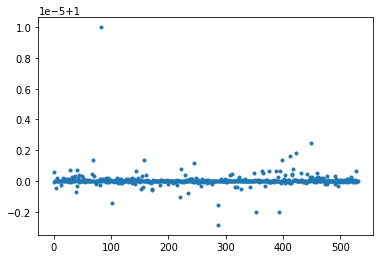

In [25]:
# Check what happened to the area ratios after this polygon polishing
area_ratios_array = np.array(area_ratios)
print(f"min = {area_ratios_array.min()}, max = {area_ratios_array.max()}, mean = {area_ratios_array.mean()}")
plt.plot(area_ratios_array, linestyle='None', marker='.');

This approach seems to work:
- Area ratios stay very close to 1, despite there being a handful of polygons that are in the order of several MERIT Hydro DEM pixels size;
- Visual inspection of cleaned polygons confirms all tendrils are gone.

So now we'll run it for real and replace the outlet geometries with the new ones, and save back to file.

### Run it for real

In [44]:
# Define the precision level
precision = 1e-08

# Loop over all basins with a multipolygon outlet
area_ratios = []
for basin in basins_with_outlet_to_check: # <str> : "CAN_01AD002"
    
    # Load the basin and river shapes
    print(f"Running {basin}")
    dist_shp_basin = basin_path / basin / 'shapefiles' / 'distributed' / (basin + '_distributed_basin.shp')
    dist_shp_river = basin_path / basin / 'shapefiles' / 'distributed' / (basin + '_distributed_river.shp')
    shp_basin = gpd.read_file(dist_shp_basin)
    shp_river = gpd.read_file(dist_shp_river)
    
    # Find most downstream polygon
    outlet = find_outlet(shp_river)
    
    # Extract the relevant row and geometry
    outlet_row = shp_basin[shp_basin['COMID'] == outlet]
    outlet_id = int(np.where(shp_basin['COMID'] == outlet)[0])
    outlet_gm = shp_basin.iloc[outlet_id]['geometry']
    
    # Create the simplified geometry
    precise_geom = set_precision(outlet_row.loc[outlet_id]['geometry'],precision)
    
    # Run the area check
    area_tol = 1e-5
    area_ratio = precise_geom.area / outlet_gm.area
    assert abs(area_ratio - 1) <= area_tol, f"area ratio outside tolerance {area_tol}"
    area_ratios.append(area_ratio)
    
    # Replace the geometry
    shp_basin.at[outlet_id, 'geometry'] = precise_geom
    
    # Save back to file
    shp_basin.to_file(dist_shp_basin)

Running CAN_01AD002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_01AL002
Running CAN_01AN002
Running CAN_01AP002
Running CAN_01AP004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_01AP006
Running CAN_01BD008
Running CAN_01BE001
Running CAN_01BG005


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_01BG009
Running CAN_01BH010
Running CAN_01BJ007


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_01BJ010
Running CAN_01BO001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_01BQ001
Running CAN_01BV006
Running CAN_01EC001
Running CAN_01EO001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_01FA001
Running CAN_01FB001
Running CAN_01FB003
Running CAN_02AB008
Running CAN_02BA003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02BB003
Running CAN_02BF002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02BF004
Running CAN_02CA002
Running CAN_02CB003
Running CAN_02DC012


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02DD015
Running CAN_02EA005
Running CAN_02EA010
Running CAN_02EC011
Running CAN_02ED003
Running CAN_02ED026


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02FE011
Running CAN_02FE014
Running CAN_02FF007
Running CAN_02GA018
Running CAN_02GC002
Running CAN_02GC029


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02GG002
Running CAN_02GG009
Running CAN_02HB023
Running CAN_02HC019
Running CAN_02HC047
Running CAN_02HC049


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02HD012
Running CAN_02HK007
Running CAN_02HL004
Running CAN_02JB013


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02JC008
Running CAN_02LA007
Running CAN_02LB008
Running CAN_02LD005


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02NE011
Running CAN_02NF003
Running CAN_02OD003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02OE032
Running CAN_02PA007


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02PC019
Running CAN_02PD002
Running CAN_02PL005
Running CAN_02QA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02QC009
Running CAN_02RG005
Running CAN_02UA003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02UC002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02VB004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02WB003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02XA003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02XC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02YJ001
Running CAN_02YK005
Running CAN_02YL001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02YM003
Running CAN_02YM004
Running CAN_02YQ001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_02YR001
Running CAN_02YS006
Running CAN_02ZC002
Running CAN_02ZD002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_02ZH001
Running CAN_02ZH002
Running CAN_02ZJ003
Running CAN_03AB002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_03AC004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_03BD002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_03KC004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_03NF001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_03OC003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_03QC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_03QC002
Running CAN_04AB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04AD002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04CA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04CA003
Running CAN_04CB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04DA001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04DC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04FA001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04FA003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04FB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04GA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04GB004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04GB005
Running CAN_04JF001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04LM001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_04MD004
Running CAN_04NA001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05AA004
Running CAN_05AH037
Running CAN_05AH050
Running CAN_05BB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05BJ004
Running CAN_05BK001
Running CAN_05BM014
Running CAN_05CB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05CC009
Running CAN_05CE002
Running CAN_05CE018
Running CAN_05DB006


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05DF004
Running CAN_05EA002
Running CAN_05EA005


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05EC005
Running CAN_05EE009
Running CAN_05FA024
Running CAN_05FB002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05FC002
Running CAN_05GA008


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05GA010
Running CAN_05GA012


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05GG010
Running CAN_05HA015
Running CAN_05HD036
Running CAN_05HE001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05JB004
Running CAN_05JB007
Running CAN_05JF011
Running CAN_05JG013
Running CAN_05JJ009


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05JM010
Running CAN_05KB003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05KE007
Running CAN_05KG007


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05LB006


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05LC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05LH005


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05LJ005
Running CAN_05LJ007
Running CAN_05LL015
Running CAN_05MC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05MC002
Running CAN_05MD005
Running CAN_05ME003
Running CAN_05MF001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05MG003
Running CAN_05NG010
Running CAN_05OA007


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05OB010
Running CAN_05OB021
Running CAN_05OC022
Running CAN_05OE004
Running CAN_05OE006
Running CAN_05OH007


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05OJ017
Running CAN_05PB014


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05PH003
Running CAN_05QA004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05QE008
Running CAN_05QE009
Running CAN_05RB003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05RC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05RE002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05SA002
Running CAN_05SC002
Running CAN_05SD003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05TD001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05TE002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_05TF002
Running CAN_05TG002
Running CAN_05TG006
Running CAN_05UA003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_05UF004
Running CAN_05UH001
Running CAN_06AB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06AB002
Running CAN_06AD001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06AD010
Running CAN_06BA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06BB003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06BB005


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06BD001
Running CAN_06CD002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06DA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06DA004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06DA005
Running CAN_06DC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06FA001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06FC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06GD001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06HB002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06JC002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06LA001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06LC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_06MA006


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07AC001
Running CAN_07AF002
Running CAN_07AG003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07AH002
Running CAN_07BB011
Running CAN_07BJ001
Running CAN_07CA003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_07CA013
Running CAN_07CD001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07CE003
Running CAN_07DA018
Running CAN_07DB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07DC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07EC004
Running CAN_07ED003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07EE010
Running CAN_07FA003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07FB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07FB006
Running CAN_07FC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07FC003
Running CAN_07FD007


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07FD011
Running CAN_07FD013
Running CAN_07GC002
Running CAN_07GD001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_07GE007
Running CAN_07GF001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07GJ001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07HA003
Running CAN_07HC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07JC002
Running CAN_07JD002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07JF003
Running CAN_07KE001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07LB002
Running CAN_07LE002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07MA003
Running CAN_07MB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07OB003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07OB004
Running CAN_07OC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07QD002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07RD001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07SA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07SA004
Running CAN_07SB017


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_07SC002
Running CAN_08AA007
Running CAN_08AA008


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08AC002
Running CAN_08CF003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08CG001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08DB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08EB004
Running CAN_08ED001
Running CAN_08ED002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08EE008
Running CAN_08FA002
Running CAN_08FB006


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_08FC003
Running CAN_08FF001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08FF003
Running CAN_08GD004
Running CAN_08HB014
Running CAN_08HB074
Running CAN_08HD011
Running CAN_08HF005
Running CAN_08HF006
Running CAN_08JD006


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_08JE001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08JE004
Running CAN_08KB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08KB003
Running CAN_08KC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08KH006


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08LB064


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08LB076
Running CAN_08LC040
Running CAN_08LD001
Running CAN_08LE027


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_08LE031


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08LF023


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08LG048
Running CAN_08MB005


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08MB006
Running CAN_08MB007
Running CAN_08ME027
Running CAN_08MF068
Running CAN_08MG005


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_08MG013


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08MG020
Running CAN_08MH029


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08MH103
Running CAN_08MH147
Running CAN_08NC004
Running CAN_08NE006
Running CAN_08NE074


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_08NG065


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08NH032
Running CAN_08NH119
Running CAN_08NL038


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08NM174
Running CAN_08NN002
Running CAN_08NN012


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_08NN023
Running CAN_08OA002
Running CAN_09AE006
Running CAN_09AG001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running CAN_09AH003
Running CAN_09AH004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_09BA001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_09BC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_09BC004


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_09CB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_09DB001
Running CAN_09DD003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_09EA003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_09FB002
Running CAN_09FC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_09FD002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10BE001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10BE004
Running CAN_10BE007
Running CAN_10CA001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10CD001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10CD003
Running CAN_10ED001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10ED002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10FB005
Running CAN_10GB006


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10JA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10JC003


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10KB001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10LA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10LC007
Running CAN_10MC002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10NC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10PC005


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10QC001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10QD001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10RA001


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_10RA002


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running CAN_11AA026
Running CAN_11AA032
Running CAN_11AB117
Running CAN_11AC025
Running CAN_11AE009


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_01022500
Running USA_01031500
Running USA_01055000
Running USA_01057000
Running USA_01134500
Running USA_01144000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_01169000
Running USA_01350000
Running USA_01413500
Running USA_01423000
Running USA_01439500
Running USA_01440400


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_01451800
Running USA_01487000
Running USA_01491000
Running USA_01510000
Running USA_01518862
Running USA_01539000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_01543500
Running USA_01544500
Running USA_01548500
Running USA_01552000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_01606500
Running USA_01632000
Running USA_01634500
Running USA_01644000
Running USA_02014000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_02051000
Running USA_02051500
Running USA_02053800
Running USA_02064000
Running USA_02081500
Running USA_02092500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_02108000
Running USA_02112360
Running USA_02118500
Running USA_02128000
Running USA_02152100
Running USA_02178400


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_02212600
Running USA_02231000
Running USA_02231342
Running USA_02235200
Running USA_02246000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_02298123
Running USA_02298608
Running USA_02310947
Running USA_02342933
Running USA_02363000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_02369800
Running USA_02395120
Running USA_02408540
Running USA_02415000
Running USA_02450250
Running USA_03066000
Running USA_03070500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_03144000
Running USA_03159540
Running USA_03164000
Running USA_03173000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_03180500
Running USA_03237500
Running USA_03281500
Running USA_03285000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_03366500
Running USA_03439000
Running USA_03460000
Running USA_03479000
Running USA_03498500
Running USA_03592718


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_04024430
Running USA_04040500
Running USA_04043050
Running USA_04045500
Running USA_04057510
Running USA_04057800
Running USA_04124000
Running USA_04127997


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_04196800
Running USA_04197100
Running USA_04216418
Running USA_04221000
Running USA_05057000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_05062500
Running USA_05120500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_05123400
Running USA_05399500
Running USA_05412500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_05444000
Running USA_05466500
Running USA_05489000
Running USA_05514500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_05584500
Running USA_05585000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_05592050
Running USA_05593575
Running USA_06043500
Running USA_06280300


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_06289000
Running USA_06339500
Running USA_06350000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_06352000
Running USA_06353000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_06354000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_06360500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_06404000
Running USA_06409000
Running USA_06447500
Running USA_06450500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_06468250
Running USA_06470800


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_06814000
Running USA_06847900
Running USA_06885500
Running USA_06892000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_06903400
Running USA_06906800
Running USA_06910800
Running USA_06917000
Running USA_06918460


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_06919500
Running USA_06921200
Running USA_06934000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_07066000
Running USA_07148400
Running USA_07196900
Running USA_07197000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_07226500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_07290650
Running USA_07299670
Running USA_07301500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_07340300
Running USA_07362100
Running USA_07373000
Running USA_08066300
Running USA_08086212


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_08086290
Running USA_08150800
Running USA_08164000
Running USA_08164300


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_08171300
Running USA_08176900
Running USA_08190500
Running USA_08194200


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_08196000
Running USA_08324000
Running USA_09066000
Running USA_09107000
Running USA_09210500
Running USA_09223000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_09306242
Running USA_09484600
Running USA_09505200
Running USA_09505350
Running USA_09512280
Running USA_10166430


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_10205030
Running USA_10242000
Running USA_11151300
Running USA_11224500
Running USA_11266500
Running USA_11468500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_11481200
Running USA_11482500
Running USA_11522500
Running USA_11523200
Running USA_12013500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Running USA_12092000
Running USA_12095000
Running USA_12358500
Running USA_12414500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_13240000
Running USA_13340000


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Running USA_14020000
Running USA_14139800
Running USA_14236200
Running USA_14306500


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

min = 0.999997142764634, max = 1.0000099966530906, mean = 1.0000000419282247


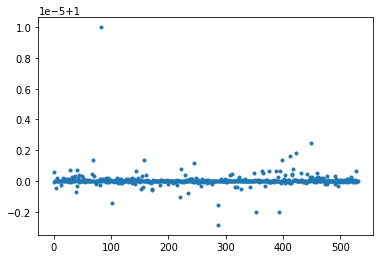

In [46]:
# Confirm the area ratios are as expected
area_ratios_array = np.array(area_ratios)
print(f"min = {area_ratios_array.min()}, max = {area_ratios_array.max()}, mean = {area_ratios_array.mean()}")
plt.plot(area_ratios_array, linestyle='None', marker='.');

### --- DEV
Down here are various attempts to get rid of these tendrils before settling on the set_precision method. Keeping for posterity.

In [21]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [133]:
# Get an example basin
basin_str = basins_with_outlet_to_fix[1]
dist_shp_basin = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_basin.shp')
dist_shp_river = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_river.shp')
shp_basin = gpd.read_file(dist_shp_basin)
shp_river = gpd.read_file(dist_shp_river)
outlet = find_outlet(shp_river)

In [134]:
# Extract the relevant row and geometry
outlet_row = shp_basin[shp_basin['COMID'] == outlet]
outlet_id = int(np.where(shp_basin['COMID'] == outlet)[0])
outlet_gm = shp_basin.iloc[outlet_id]['geometry']

<AxesSubplot:>

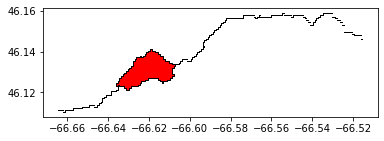

In [135]:
# Plot the problem
gpd.GeoSeries([outlet_gm]).plot(color='red', edgecolor='black')

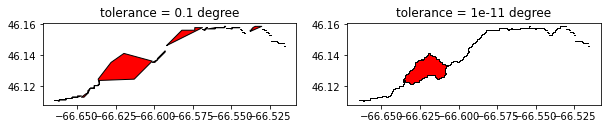

In [136]:
# Does simplify() work? --- CLEARLY NOT
fig,axs = plt.subplots(1,2,figsize=(10,4))

ax = axs[0]
tolerance = 0.1
simple_geom = outlet_row['geometry'].simplify(tolerance=tolerance, preserve_topology=True)
simple_outlet_gm = simple_geom.loc[outlet_id]
gpd.GeoSeries([simple_outlet_gm]).plot(ax=ax, color='red', edgecolor='black')
ax.set_title(f"tolerance = {tolerance} degree")

ax = axs[1]
tolerance = 0.00000000001
simple_geom = outlet_row['geometry'].simplify(tolerance=tolerance, preserve_topology=True)
simple_outlet_gm = simple_geom.loc[outlet_id]
gpd.GeoSeries([simple_outlet_gm]).plot(ax=ax, color='red', edgecolor='black')
ax.set_title(f"tolerance = {tolerance} degree");

<AxesSubplot:>

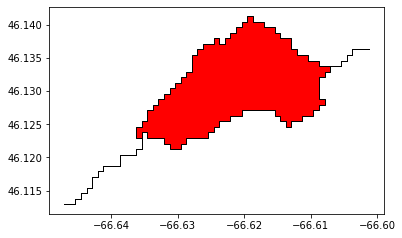

In [137]:
# Select the largest part of the polygon only - doesn't work when the tendrils are attached to it
from shapely.ops import unary_union

def filter_largest_polygon(geometry):
    return max(geometry, key=lambda a: a.area)

largest_geom = filter_largest_polygon(outlet_row.loc[outlet_id]['geometry'].geoms)
gpd.GeoSeries([largest_geom]).plot(color='red', edgecolor='black')

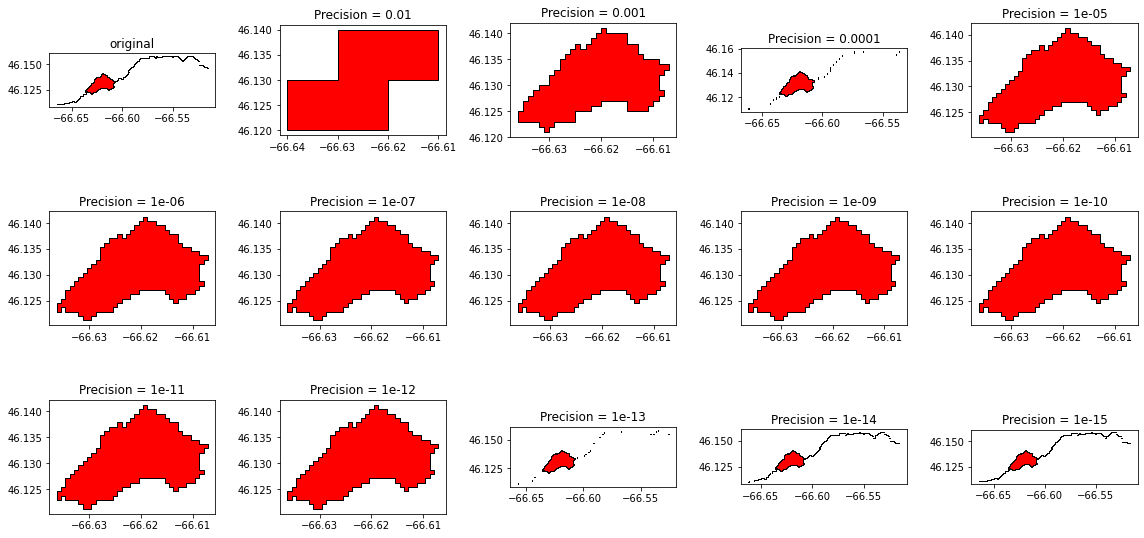

In [138]:
# Shapely set_precision
from shapely import set_precision

def plot_geom_precision_test(precision,ax):
    precise_geom = set_precision(outlet_row.loc[outlet_id]['geometry'],precision)
    if not precise_geom.is_empty:
        gpd.GeoSeries([precise_geom]).plot(ax=ax, color='red', edgecolor='black')
    ax.set_title(f"Precision = {precision}")
    
fig,axs = plt.subplots(3,5,figsize=(16,8))
axs = axs.flatten()
for ax_id,precision in zip(
    range(0,15),
    [1/(10**v) for v in range(1,16)]
):
    ax = axs[ax_id]
    if ax_id == 0:
        gpd.GeoSeries([outlet_gm]).plot(ax=ax,color='red', edgecolor='black')
        ax.set_title('original')
    else:
        plot_geom_precision_test(precision,ax)

plt.tight_layout()

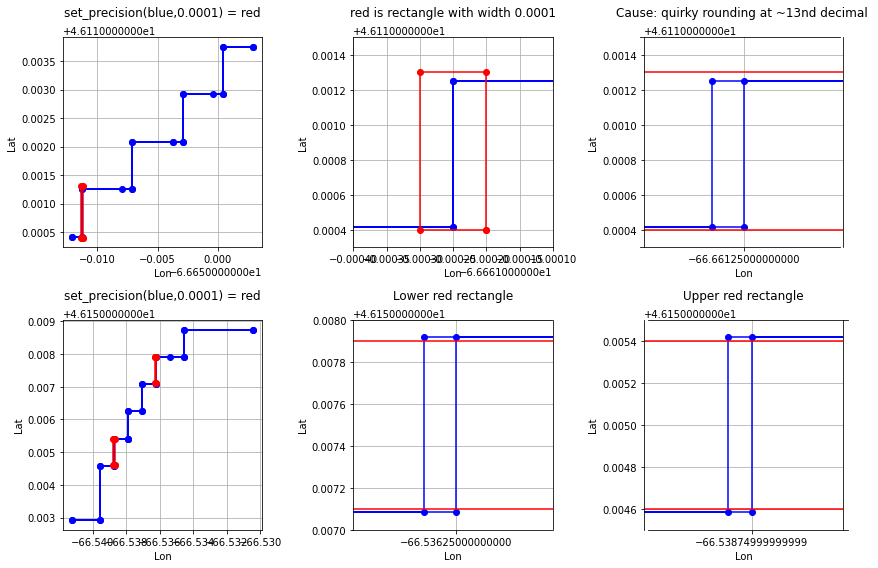

In [113]:
# Create a Matplotlib figure
fig, axs = plt.subplots(2,3,figsize=(12,8))

#### CASE 1
g1 = outlet_row.loc[outlet_id]['geometry'].geoms[1]
g2 = set_precision(g1,0.0001)

# Extract x and y coordinates from the polygon
x1, y1 = g1.exterior.xy
x2, y2 = g2.exterior.xy

# Plot the polygon
ax = axs[0,0]
ax.plot(x1, y1, color='blue', marker='o')
ax.plot(x2, y2, color='red', marker='o')

# Add labels and title
ax.set_title('set_precision(blue,0.0001) = red\n')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.grid()

# Plot the polygon
ax = axs[0,1]
ax.plot(x1, y1, color='blue', marker='o')
ax.plot(x2, y2, color='red', marker='o')

# Add labels and title
ax.set_title('red is rectangle with width 0.0001\n')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim([-66.6614,-66.6611])
ax.set_ylim([46.1103,46.1115])
ax.grid()

# Plot the polygon
ax = axs[0,2]
ax.plot(x1, y1, color='blue', marker='o')
ax.plot(x2, y2, color='red', marker='o')

# Add labels and title
ax.set_title('Cause: quirky rounding at ~13nd decimal \n')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim([-66.6612500000001,-66.6612499999999])
ax.set_ylim([46.1103,46.1115])
ax.grid()


#### CASE 2
g1 = outlet_row.loc[outlet_id]['geometry'].geoms[21]
g2 = set_precision(g1,0.0001)

# Extract x and y coordinates from the polygon
x1, y1 = g1.exterior.xy
x2, y2 = g2.geoms[0].exterior.xy
x3, y3 = g2.geoms[1].exterior.xy

# Plot the polygon
ax = axs[1,0]
ax.plot(x1, y1, color='blue', marker='o')
ax.plot(x2, y2, color='red', marker='o')
ax.plot(x3, y3, color='red', marker='o')

# Add labels and title
ax.set_title('set_precision(blue,0.0001) = red\n')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.grid()

# Plot the polygon
ax = axs[1,1]
ax.plot(x1, y1, color='blue', marker='o')
ax.plot(x2, y2, color='red', marker='o')

# Add labels and title
ax.set_title('Lower red rectangle\n')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim([-66.5362500000001,-66.5362499999999])
ax.set_ylim([46.1570,46.1580])
ax.grid()

# Plot the polygon
ax = axs[1,2]
ax.plot(x1, y1, color='blue', marker='o')
ax.plot(x2, y2, color='red', marker='o')
ax.plot(x3, y3, color='red', marker='o')

# Add labels and title
ax.set_title('Upper red rectangle\n')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim([-66.5387500000001,-66.5387499999999])
ax.set_ylim([46.1545,46.1555])
ax.grid()



# Show the plot
plt.tight_layout()

### --- END DEV